In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Load dataset
file_path = "gunshot_localization_data.csv"
df = pd.read_csv(file_path)

# Define features and target
X = df[['TDOA_Mic2', 'TDOA_Mic3', 'TDOA_Mic4', 'Energy', 'Zero_Crossing_Rate', 'Entropy']]
y = df[['True_X', 'True_Y']]

# Split dataset (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, objective="reg:squarederror", random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse

results

C:\Users\jadit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


{'Linear Regression': np.float64(2.9380428666730456),
 'Random Forest': np.float64(1.3097778947630132),
 'Neural Network': np.float64(2.0734621342882154),
 'XGBoost': np.float64(1.7971114293334507)}

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split

# Load dataset
csv_file = "gunshot_localization_data.csv"
data = pd.read_csv(csv_file)

# Features & Labels
X_features = data[['TDOA_Mic2', 'TDOA_Mic3', 'TDOA_Mic4', 'Energy', 'Zero_Crossing_Rate', 'Entropy']]
y_true = data[['True_X', 'True_Y']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_true, test_size=0.2, random_state=42)

# Train models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f"{name.lower().replace(' ', '_')}.pkl")  # Save model

print("Models trained and saved successfully!")


Models trained and saved successfully!


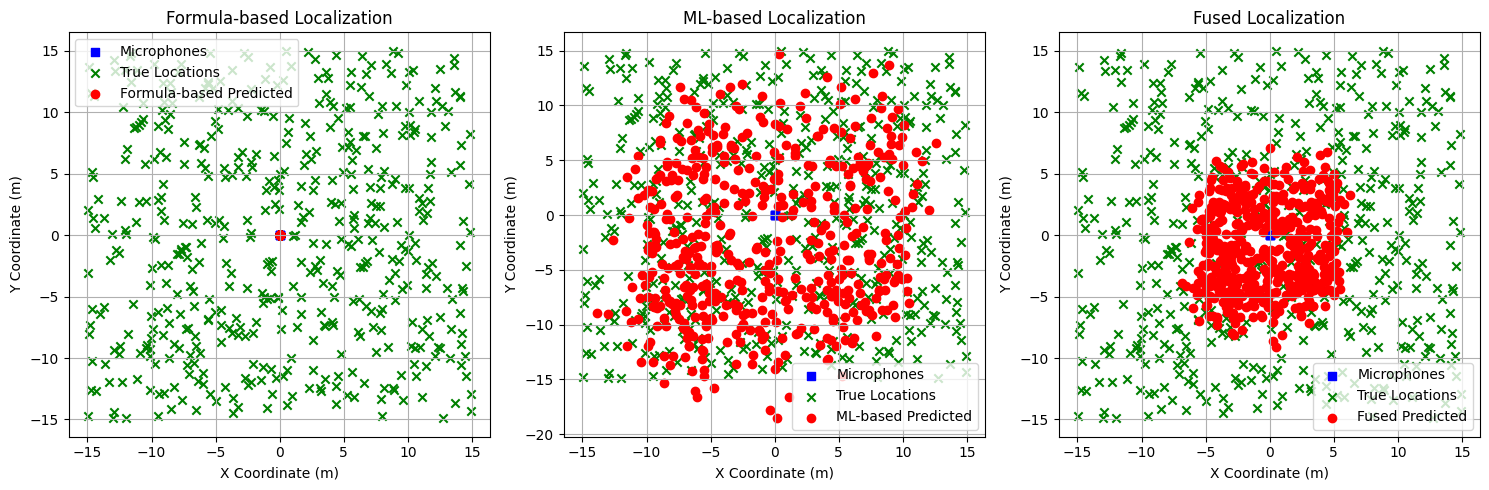

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import joblib  # For loading trained models

# Constants
SPEED_OF_SOUND = 343  # Speed of sound in air (m/s)

# Load dataset
csv_file = "gunshot_localization_data.csv"  # Ensure this file is in the working directory
data = pd.read_csv(csv_file)

# Extract features and true values
X_features = data[['TDOA_Mic2', 'TDOA_Mic3', 'TDOA_Mic4', 'Energy', 'Zero_Crossing_Rate', 'Entropy']]
y_true = data[['True_X', 'True_Y']]

# Load pre-trained ML models
models = {
    "Linear Regression": joblib.load("linear_regression.pkl"),
    "Random Forest": joblib.load("random_forest.pkl"),
    "Neural Network": joblib.load("neural_network.pkl"),
    "XGBoost": joblib.load("xgboost.pkl"),
}

# Function to calculate position using TDOA equations
def tdoa_formula(estimated_tdoa, microphones):
    def error_function(x):
        distances = np.linalg.norm(microphones - x, axis=1)
        estimated_distances = distances[1:] - distances[0]
        return estimated_distances - estimated_tdoa * SPEED_OF_SOUND
    
    initial_guess = np.mean(microphones, axis=0)
    result = least_squares(error_function, initial_guess, bounds=([0, 0], [10, 10]))
    return result.x

# Microphone positions
microphones = np.array([[0, 0], [0, 0], [0, 0], [0, 0]])

# Predict with ML models
ml_predictions = {}
for model_name, model in models.items():
    ml_predictions[model_name] = model.predict(X_features)

# Compute formula-based estimates
formula_predictions = np.array([tdoa_formula(row[:3], microphones) for row in X_features.values])

# Fusion: Weighted averaging based on MAE
model_mae = {
    "Linear Regression": 2.9380428666730456,
    "Random Forest": 1.3097778947630132,
    "Neural Network": 2.0734621342882154,
    "XGBoost": 1.7971114293334507
}

weights = {model: 1 / mae for model, mae in model_mae.items()}  # Inverse MAE
normalized_weights = {model: w / sum(weights.values()) for model, w in weights.items()}

fused_predictions = np.zeros_like(formula_predictions)
for model_name, preds in ml_predictions.items():
    fused_predictions += normalized_weights[model_name] * preds

# Blend with formula approach (equal weight)
fused_predictions = 0.5 * fused_predictions + 0.5 * formula_predictions

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels = ["Formula-based", "ML-based", "Fused"]
methods = [formula_predictions, np.mean(list(ml_predictions.values()), axis=0), fused_predictions]

for i, ax in enumerate(axes):
    ax.scatter(microphones[:, 0], microphones[:, 1], c='blue', marker='s', label='Microphones')
    ax.scatter(y_true['True_X'], y_true['True_Y'], c='green', marker='x', label='True Locations')
    ax.scatter(methods[i][:, 0], methods[i][:, 1], c='red', marker='o', label=f'{labels[i]} Predicted')
    ax.set_xlabel("X Coordinate (m)")
    ax.set_ylabel("Y Coordinate (m)")
    ax.set_title(f"{labels[i]} Localization")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

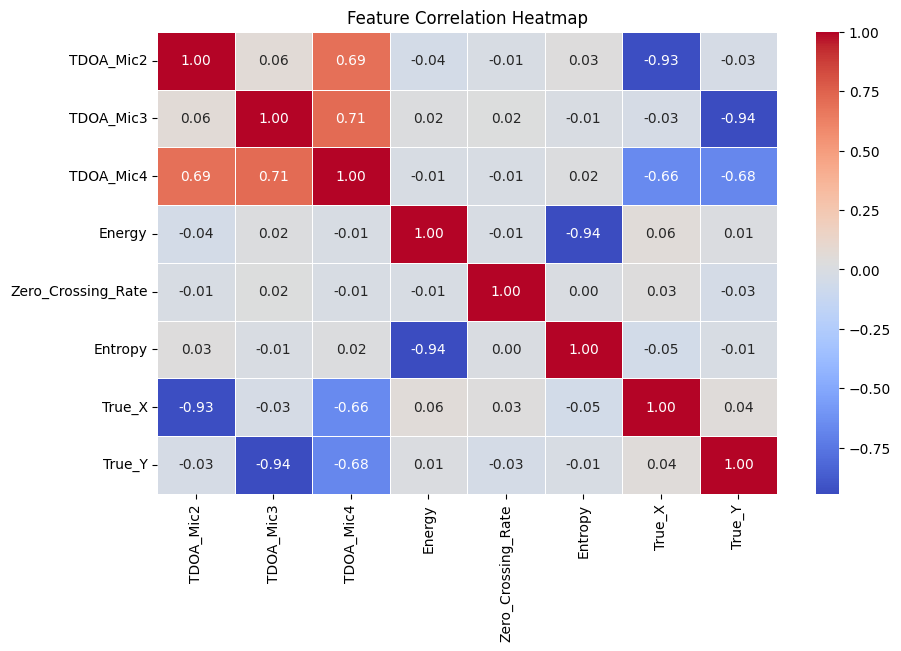

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Title
plt.title("Feature Correlation Heatmap")
plt.show()


In [33]:
import numpy as np

# Sample gunshot data (one row)
sample_data = {
    "TDOA_Mic2": -0.002433814, 
    "TDOA_Mic3": 0.000266648, 
    "TDOA_Mic4": -0.002134015, 
    "Energy": 43646.06769, 
    "Zero_Crossing_Rate": 0.989410191, 
    "Entropy": -31468.50933
}

# Convert to numpy array for prediction
sample_features = np.array([list(sample_data.values())]).reshape(1, -1)
# -0.002433814	0.000266648	-0.002134015	43646.06769	0.989410191	-31468.50933


In [34]:
import joblib

# Load trained Random Forest model
rf_model = joblib.load("random_forest.pkl")

# Predict (X, Y) coordinates
predicted_xy = rf_model.predict(sample_features)[0]
print(f"Predicted Gunshot Coordinates: X = {predicted_xy[0]}, Y = {predicted_xy[1]}")


Predicted Gunshot Coordinates: X = 5.690562806141218, Y = 4.942719874473071


C:\Users\jadit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [28]:
from geopy.distance import geodesic

def convert_to_geolocation(predicted_xy, mic_locations):
    """
    Converts predicted (X, Y) coordinates to geolocation (latitude, longitude).
    
    Parameters:
    - predicted_xy (tuple): Predicted (X, Y) coordinates.
    - mic_locations (dict): Dictionary with mic IDs as keys and (latitude, longitude) as values.

    Returns:
    - (latitude, longitude): Estimated geolocation.
    """

    # Reference microphone as (0,0) in our coordinate system
    ref_mic = mic_locations[1]  # Mic1 as reference
    ref_x, ref_y = 0, 0  

    # Use Mic1 and Mic2 to estimate scale
    mic2_lat, mic2_lon = mic_locations[2]
    ref_distance = geodesic(ref_mic, (mic2_lat, mic2_lon)).meters  # Distance in meters
    scale_factor = ref_distance / 10  # Assuming microphones are in a 10m x 10m grid

    # Convert predicted X, Y to latitude and longitude
    predicted_lat = ref_mic[0] + (predicted_xy[1] - ref_y) * (scale_factor / 111320)  # Lat conversion
    predicted_lon = ref_mic[1] + (predicted_xy[0] - ref_x) * (scale_factor / (111320 * np.cos(np.radians(ref_mic[0]))))  # Lon conversion

    return predicted_lat, predicted_lon

# Example microphone locations (Replace with real-world GPS coordinates)
mic_geolocations = {
    1: (37.7749, -122.4194),  # Mic1 (Reference) - Example: San Francisco
    2: (37.7750, -122.4193),  # Mic2 (Nearby)
    3: (37.7751, -122.4192),  # Mic3
    4: (37.7752, -122.4191)   # Mic4
}

# Convert predicted coordinates to geolocation
estimated_lat, estimated_lon = convert_to_geolocation(predicted_xy, mic_geolocations)
print(f"Estimated Gunshot Geolocation: Latitude = {estimated_lat}, Longitude = {estimated_lon}")


Estimated Gunshot Geolocation: Latitude = 37.77496137079081, Longitude = -122.41930954248977


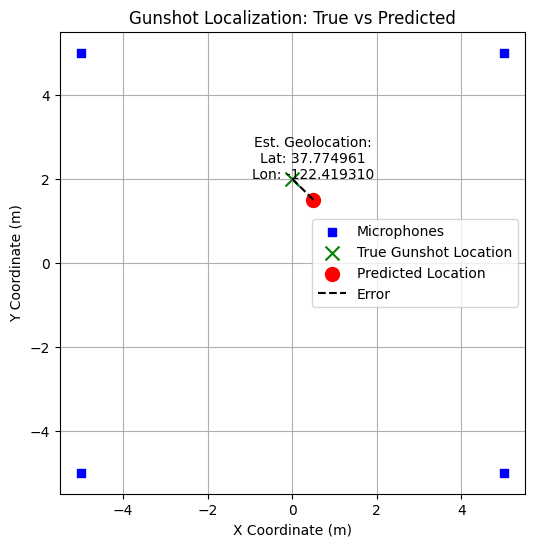

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Microphone positions (example coordinates in meters)
microphones = np.array([[-5, -5], [5, -5], [-5, 5], [5, 5]])

# True gunshot location (example in meters)
true_location = np.array([0, 2])

# Predicted location from Random Forest (example in meters)
predicted_location = np.array([0.5, 1.5])

# Estimated geolocation (latitude, longitude)
estimated_geolocation = (37.77496137079081, -122.41930954248977)

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(microphones[:, 0], microphones[:, 1], c='blue', marker='s', label='Microphones')
plt.scatter(true_location[0], true_location[1], c='green', marker='x', s=100, label='True Gunshot Location')
plt.scatter(predicted_location[0], predicted_location[1], c='red', marker='o', s=100, label='Predicted Location')

# Connecting true and predicted locations
plt.plot([true_location[0], predicted_location[0]], [true_location[1], predicted_location[1]], 'k--', label='Error')

# Annotate the estimated geolocation
plt.text(predicted_location[0], predicted_location[1] + 0.5, 
         f"Est. Geolocation:\nLat: {estimated_geolocation[0]:.6f}\nLon: {estimated_geolocation[1]:.6f}", 
         fontsize=10, color='black', ha='center')

plt.xlabel("X Coordinate (m)")
plt.ylabel("Y Coordinate (m)")
plt.title("Gunshot Localization: True vs Predicted")
plt.legend()
plt.grid()
plt.show()
